In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [2]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),       
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),   
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [3]:
def potential(x,k,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    
    poten=-10/x+x
    return poten

In [4]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [8]:
step_list=[i*(i+1)/400 for i in range(200)]
print(step_list[-1])
end=step_list[-1]+1
while end<400:
    step_list.append(end)
    end+=1
print(len(step_list))
print(step_list) 
    

99.5
500
[0.0, 0.005, 0.015, 0.03, 0.05, 0.075, 0.105, 0.14, 0.18, 0.225, 0.275, 0.33, 0.39, 0.455, 0.525, 0.6, 0.68, 0.765, 0.855, 0.95, 1.05, 1.155, 1.265, 1.38, 1.5, 1.625, 1.755, 1.89, 2.03, 2.175, 2.325, 2.48, 2.64, 2.805, 2.975, 3.15, 3.33, 3.515, 3.705, 3.9, 4.1, 4.305, 4.515, 4.73, 4.95, 5.175, 5.405, 5.64, 5.88, 6.125, 6.375, 6.63, 6.89, 7.155, 7.425, 7.7, 7.98, 8.265, 8.555, 8.85, 9.15, 9.455, 9.765, 10.08, 10.4, 10.725, 11.055, 11.39, 11.73, 12.075, 12.425, 12.78, 13.14, 13.505, 13.875, 14.25, 14.63, 15.015, 15.405, 15.8, 16.2, 16.605, 17.015, 17.43, 17.85, 18.275, 18.705, 19.14, 19.58, 20.025, 20.475, 20.93, 21.39, 21.855, 22.325, 22.8, 23.28, 23.765, 24.255, 24.75, 25.25, 25.755, 26.265, 26.78, 27.3, 27.825, 28.355, 28.89, 29.43, 29.975, 30.525, 31.08, 31.64, 32.205, 32.775, 33.35, 33.93, 34.515, 35.105, 35.7, 36.3, 36.905, 37.515, 38.13, 38.75, 39.375, 40.005, 40.64, 41.28, 41.925, 42.575, 43.23, 43.89, 44.555, 45.225, 45.9, 46.58, 47.265, 47.955, 48.65, 49.35, 50.055, 50

In [5]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

La=0
Lb =50
L=Lb-La  # domain length
N = 1000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)

# 控制势函数的大小
l_max=4
scale=10

en_num=30
extend_num=10
epoch=200000
lr=0.01

diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

In [6]:
real_en_list=[]
for l in range(l_max):
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid,b_lap,scale)+centrifugal_poten
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    real_en=eigenvalues[:en_num].detach()
    real_en_list.append(real_en)

In [7]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=80,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    
    loss=0
    for l in range(l_max):
        centrifugal_poten=-b_lap*(l+1)*l/grid**2
        V_diag=model(grid)+centrifugal_poten
        A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
        eigenvalues= torch.linalg.eigvalsh(A)
        output=eigenvalues[:en_num]
        
        loss+=loss_fn(output,real_en_list[l])
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:42.922157287597656,time:0.18062782287597656,lr:0.01
epoch:10,loss:7.367879390716553,time:0.6093897819519043,lr:0.01
epoch:20,loss:7.794015407562256,time:1.0293538570404053,lr:0.01
epoch:30,loss:4.378121376037598,time:1.4500973224639893,lr:0.01
epoch:40,loss:6.9603190422058105,time:1.8731679916381836,lr:0.01
epoch:50,loss:5.002402305603027,time:2.2958691120147705,lr:0.01
epoch:60,loss:6.4931817054748535,time:2.722579002380371,lr:0.01
epoch:70,loss:5.86288595199585,time:3.145516872406006,lr:0.01
epoch:80,loss:2.0703141689300537,time:3.566606283187866,lr:0.01
epoch:90,loss:3.600635290145874,time:3.9941043853759766,lr:0.01
epoch:100,loss:6.947651386260986,time:4.417046070098877,lr:0.01
epoch:110,loss:1.821721076965332,time:4.850727796554565,lr:0.01
epoch:120,loss:4.430512428283691,time:5.268572092056274,lr:0.01
epoch:130,loss:2.0134854316711426,time:5.6895575523376465,lr:0.01
epoch:140,loss:2.8770530223846436,time:6.115962743759155,lr:0.01
epoch:150,loss:2.0322797298431396,tim

In [8]:
# -1.5237e-01, -1.3085e-01, -1.2296e-01, -1.0179e-01, -7.9435e-02,
#         -5.6185e-02, -3.5326e-02, -1.0974e-02,  1.4396e-02,  4.2974e-02
# -1.2695e-01, -9.2922e-02, -5.8262e-02, -2.2549e-02,  1.4835e-02,
#          5.1943e-02,  9.0080e-02,  1.2834e-01,  1.6763e-01,  2.0718e-01

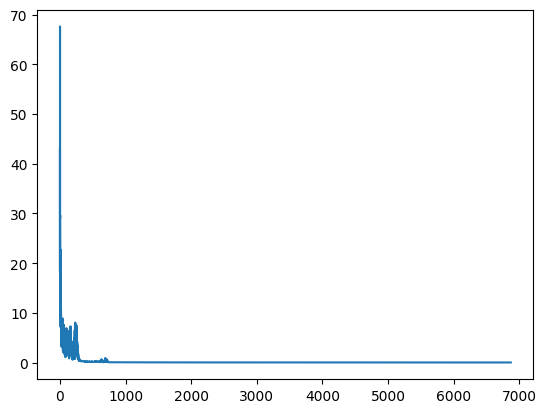

In [9]:
plt.plot(loss_list)
plt.show()

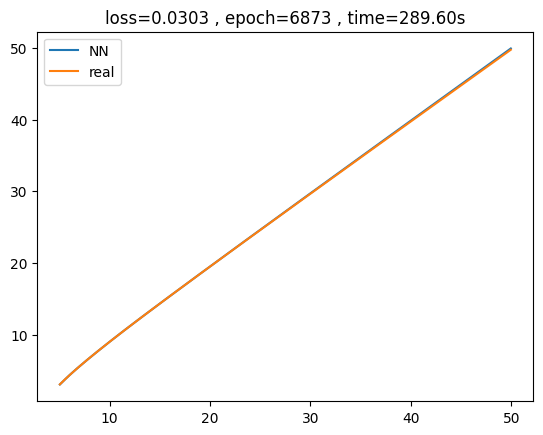

In [10]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[100:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()


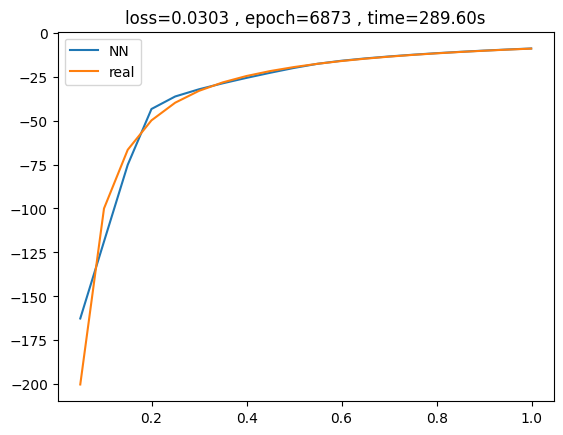

In [11]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[:20]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

In [12]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num]

real_en=real_en_list[0]
error=output-real_en
rela_error=error/real_en
print('final error:',error)
print('relative error:',rela_error)

final error: tensor([0.0003, 0.0200, 0.0124, 0.0157, 0.0116, 0.0226, 0.0143, 0.0179, 0.0177,
        0.0186, 0.0173, 0.0175, 0.0185, 0.0191, 0.0201, 0.0208, 0.0209, 0.0207,
        0.0204, 0.0200, 0.0198, 0.0196, 0.0195, 0.0196, 0.0197, 0.0198, 0.0200,
        0.0202, 0.0206, 0.0210], device='cuda:4', grad_fn=<SubBackward0>)
relative error: tensor([-6.7277e-06, -1.7078e-03, -2.9411e-03, -1.6504e-02,  1.0668e-02,
         8.5935e-03,  3.6544e-03,  3.5674e-03,  2.9335e-03,  2.6714e-03,
         2.2176e-03,  2.0259e-03,  1.9634e-03,  1.8818e-03,  1.8515e-03,
         1.7975e-03,  1.7135e-03,  1.6056e-03,  1.5083e-03,  1.4190e-03,
         1.3432e-03,  1.2797e-03,  1.2288e-03,  1.1904e-03,  1.1593e-03,
         1.1304e-03,  1.1062e-03,  1.0871e-03,  1.0748e-03,  1.0685e-03],
       device='cuda:4', grad_fn=<DivBackward0>)


energy level while l=0


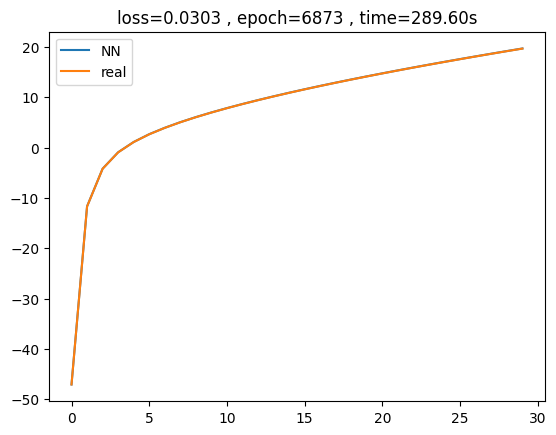

In [13]:
print('energy level while l=0')
plt.plot(output[:].detach().cpu().numpy(),label='NN')
plt.plot(real_en[:].detach().cpu().numpy(),label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

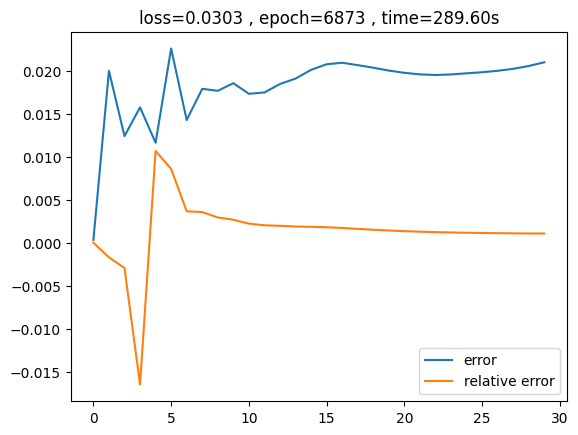

In [14]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(rela_error.detach().cpu().numpy(),label='relative error')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()